In [1]:
# Import modules:
import sys
import gmsh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Simple 2d geometry:
#  F---E    
#  |     \
#  |       D----C   -> subdomains  D1
#  |            |                  D2
#  A------------B                  D3
h = 4.0
x_sum = 50.0
z_sum = 18.3
z_below_layer = 4.5
z_down = 6.1
layer_width = 0.5
x_up = 18.3
x_down = 20.0
y_sum = 20.0

In [3]:
# Initialize gmsh:
gmsh.initialize()
factory = gmsh.model.occ

# Corner points:
A = factory.add_point(0, 0, 0)
B = factory.add_point(x_sum, 0, 0)
C = factory.add_point(x_sum, 0, z_down)
D = factory.add_point(x_sum-x_down, 0, z_down)
E = factory.add_point(x_up, 0, z_sum)
F = factory.add_point(0, 0, z_sum)

# Boundary segments:
AB = factory.add_line(A, B)
BC = factory.add_line(B, C)
CD = factory.add_line(C, D)
DE = factory.add_line(D, E)
EF = factory.add_line(E, F)
FA = factory.add_line(F, A)

ABCDEF = factory.add_curve_loop([AB, BC, CD, DE, EF, FA])
whole_slope = factory.add_plane_surface([ABCDEF])

# Thin layer (rectangle):
LA = factory.add_point(0, 0, z_below_layer)
LB = factory.add_point(x_sum, 0, z_below_layer)
LC = factory.add_point(x_sum, 0, z_below_layer+layer_width)
LD = factory.add_point(0, 0, z_below_layer+layer_width)
LAB = factory.add_line(LA, LB)
LBC = factory.add_line(LB, LC)
LCD = factory.add_line(LC, LD)
LDA = factory.add_line(LD, LA)
LABCD = factory.add_curve_loop([LAB, LBC, LCD, LDA])
thin_layer = factory.add_plane_surface([LABCD])

# Three subdomains:
factory.cut([(2, whole_slope)], [(2, thin_layer)], removeTool=False)

# Extrude to 3d:
factory.extrude(factory.get_entities(2), 0, y_sum, 0)

# Synchronize and generate mesh:
factory.remove_all_duplicates()
factory.synchronize()
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), h)
gmsh.model.mesh.generate()
gmsh.model.mesh.remove_duplicate_nodes()
gmsh.model.mesh.remove_duplicate_elements()

# Write mesh data to file:
# gmsh.write("GFG.msh")

# Create graphical user interface
# if 'close' not in sys.argv:
#     gmsh.fltk.run()

# Get node coordinates:
nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes()

# Get (triangular) faces:
faceTypes, faceTags, faceNodeTags = gmsh.model.mesh.getElements(dim=2)

# Get (tetrahedral) elements:
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim=3)

# Extract X-, Y-, and Z- coordinates of all nodes from GMSH outputs:
node = np.array(nodeCoords)
node_X = node[0::3]
node_Y = node[1::3]
node_Z = node[2::3]

# All (tetrahedral) elements:
elem = elemNodeTags[0].reshape(-1, 4)
elem = elem-1  # indexing from 0

# All (triangular) faces on the boundary (including subdomains):
face = faceNodeTags[0].reshape(-1, 3)
face = face-1  # indexing from 0

# Subdomain tags for each element:
n_elem = elem.shape[0]
min_elemTag = min(elemTags[0])
material = np.zeros((n_elem,), dtype=int)
for i in range(3):
    _, tags, _ = gmsh.model.mesh.getElements(dim=3, tag=i+1)
    material[tags[0]-min_elemTag] = i+1

# Finalize the Gmsh API
gmsh.finalize()

Info    : Meshing 1D...nts                                                                                                                       
Info    : [  0%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 60%] Meshing curve 24 (Line)
Info    : [ 60%] Meshing curve 25 (Line)
Info    : [ 60%] Meshing curve 26 (Line)
Info    : [ 60%] Meshing curve 27 (Li

Text(0.5, 0.92, 'All faces on the boundary (including subdomains)')

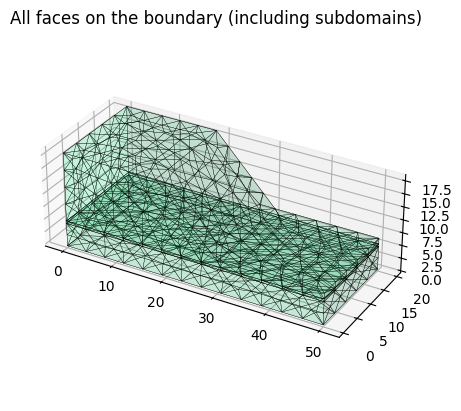

In [4]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.1])
ax.set_aspect('equal')
ax.set_title("All faces on the boundary (including subdomains)")

Text(0.5, 0.92, 'All elements')

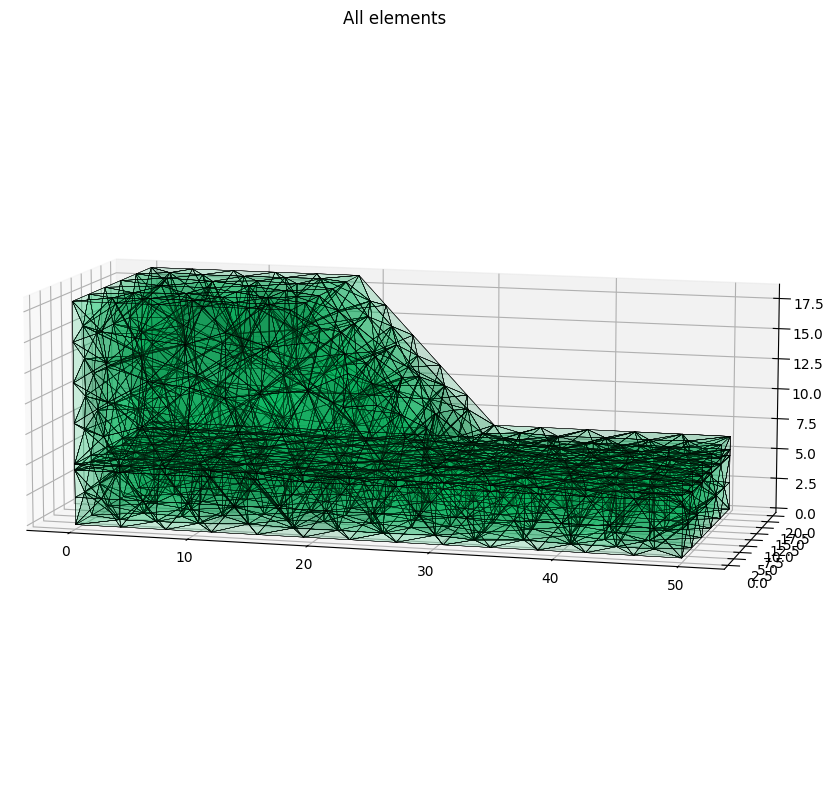

In [5]:
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')
# chnage viewing angle:
ax.view_init(10, -75)
for i in range(4):
    triangles = np.delete(elem, i, axis=1)
    ax.plot_trisurf(node_X, node_Y, node_Z, triangles=triangles, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.set_aspect('equal')
ax.set_title("All elements")

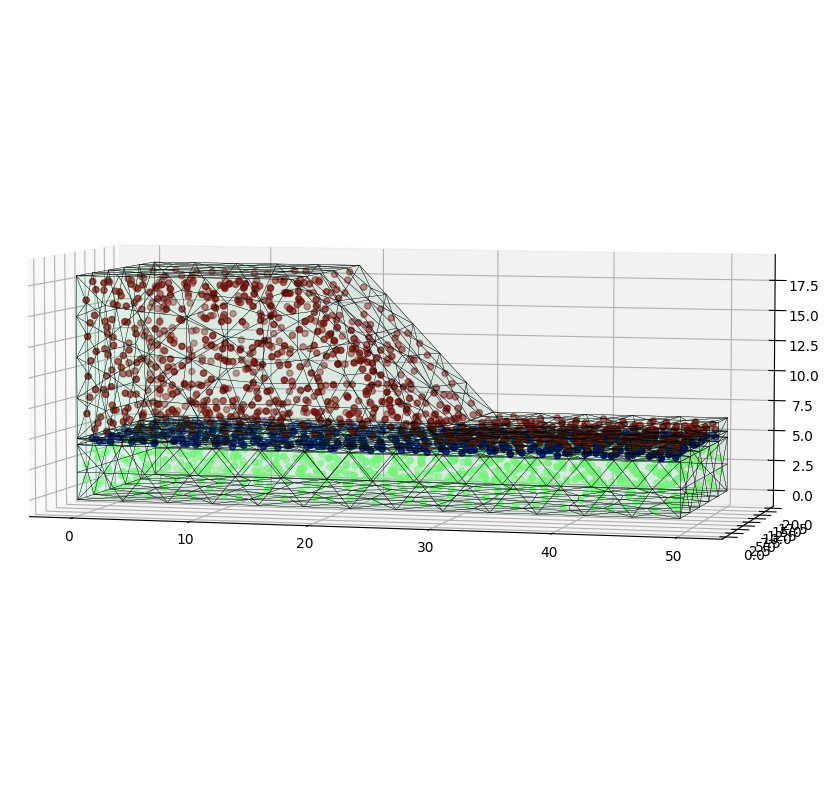

In [6]:
# show 3d scatter plot of material in each element, distinguish the material value by color:
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')
ax.view_init(5, -75)
center_X = np.mean(node_X[elem],axis=1)
center_Y = np.mean(node_Y[elem],axis=1)
center_Z = np.mean(node_Z[elem],axis=1)
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.scatter(center_X, center_Y, center_Z, c=material, cmap='jet')
ax.set_aspect('equal')
plt.show()
    